In [5]:
import chess
import chess.engine
from collections import defaultdict
import random
import numpy as np
from sarfa_saliency import computeSaliencyUsingSarfa
from sys import platform as _platform
from utils import get_all_pos, get_move_obj

In [6]:
def get_engine(engine_file = './stockfish_15_x64_avx2'):
    chess_engine = chess.engine.SimpleEngine.popen_uci(engine_file)
    return chess_engine

def q_values(board, candidate_actions, selected_action, multipv=3, runtime=2.0, use_optimal_action=False):
    options = chess_engine.analyse(board, chess.engine.Limit(time=runtime), multipv=multipv)
    if (use_optimal_action):
        selected_action = str(options[0]["pv"][0])
    
    score_per_move = defaultdict(int)

    for option in options:
        is_white_move = option['score'].turn
        score = option['score'].white() if is_white_move else option['score'].black()
        
        curr_action = str(option["pv"][0])
        if option['score'].is_mate():
            score = 40 if '+' in str(score) else -40
        else:
            score = round(score.cp/100.0, 2)
        
        score_per_move[curr_action] = score

    q_vals = {}
    for valid_move in candidate_actions:
        q_vals[str(valid_move)] = score_per_move[str(valid_move)]
    
    return q_vals, selected_action

In [7]:
def removal_perturb(board, position):
    position = get_move_obj(position)
    piece = board.piece_at(position)
    if not piece or piece == chess.Piece(chess.KING, chess.WHITE) or piece == chess.Piece(chess.KING, chess.BLACK):
        return
    
    perturbed_board = board.copy()
    perturbed_board.remove_piece_at(position)
    if perturbed_board.was_into_check():
        return 
    
    return [perturbed_board], position

def empty_space_perturb(board, position):
    position = get_move_obj(position)
    piece = board.piece_at(position)
    if not piece:
        perturbed_board = board.copy()
        new_piece = chess.Piece(chess.PAWN, chess.WHITE) if board.turn else chess.Piece(chess.PAWN, chess.BLACK)
        perturbed_board.set_piece_at(position, new_piece)
        if perturbed_board.was_into_check():
            return
        
        return [perturbed_board], position
    else:
        return

# def opp_piece_perturb(board, position):
#     position = get_move_obj(position)
#     piece = board.piece_at(position)
#     if not piece:
#         return
    
#     if piece.color and board.turn:
        
    
    

In [18]:
#########################################
num_actions = 100
runtime = 5.0
use_optimal_action = False
allow_defense = False
#########################################

# Bishop Pins Rooks
# FEN = "5rk1/6pp/1B1r4/5p2/8/2P5/PP6/1K4R1 w - - 0 1"
# action = "b6c5"

# Bishop Checks on Open Diagonal - showcases empty space perturbation
# FEN = "6N1/1pkb4/p3pQ1p/2P1P3/3P4/4q1P1/PP5P/5R1K b - - 0 33"
# action = "d7c6"

# Backrank Check protected by Knight - identifying defensive pieces?
# FEN = "6k1/1n3ppp/8/8/8/8/7P/1K1R4 w - - 0 1"
# action = "d1d8"

# More complicated Backrank Check - identify defensive pieces
# FEN = "3r2kr/5ppp/8/1n6/3B3R/8/1PP4P/RK6 b - - 0 1"
# action = "d8d4"

# Example from SARFA paper - testing relationships
FEN = '3r1rk1/1b2bpp1/p3p2p/R3N3/2pB1P2/2P3qP/PP1Q2P1/5RK1 b - - 0 1'
action = 'd8d4'


chess_engine = get_engine()
board = chess.Board(FEN)
legal_moves = set(list(board.legal_moves))
perturbation_to_qvals = dict()
perturbation_to_saliency = dict()

board_positions = get_all_pos()
for pos in board_positions:
    # can substitute for any perturb function
    perturbed_state = removal_perturb(board, pos)
    # perturbed_state = empty_space_perturb(board, pos)
    if perturbed_state is None:
        continue

    perturbed_boards, _ = perturbed_state

    # list of perturbed boards allows for perturb function to test different 
    # perturbations on the same state
    for i, perturbed_board in enumerate(perturbed_boards):
        new_legal_moves = perturbed_board.legal_moves
        candidate_actions = legal_moves.intersection(set(new_legal_moves))

        if not use_optimal_action and chess.Move.from_uci(action) not in candidate_actions:
            continue
        
        q_vals_before, selected_action = q_values(board, candidate_actions, action, multipv=num_actions, 
                                            runtime=runtime, use_optimal_action=use_optimal_action)
        q_vals_after, selected_action = q_values(perturbed_board, candidate_actions, selected_action, 
                                            multipv=num_actions, runtime=runtime, use_optimal_action=use_optimal_action)
    
        saliency, dP, K, QmaxAnswer, _, _ = computeSaliencyUsingSarfa(selected_action, q_vals_before, q_vals_after, allow_defense_check=allow_defense)
        saliency = 0 if abs(saliency) < 0.001 else saliency

        saliency_type = ""
        if dP < 0 and abs(dP) > 0.1:
            saliency_type = "Defensive "
            saliency = abs(saliency)
        
        perturbation_to_saliency[pos] = abs(saliency)
        perturbation_to_qvals[pos] = [q_vals_before, q_vals_after]
        print(f'Perturbed Board {i}, Perturbed position: {pos}, Action: {selected_action}, {saliency_type}Saliency: {saliency}')


Perturbed Board 0, Perturbed position: a2, Action: d8d4, Saliency: 0
Perturbed Board 0, Perturbed position: a5, Action: d8d4, Saliency: 0.8352971075721827
Perturbed Board 0, Perturbed position: a6, Action: d8d4, Saliency: 0
Perturbed Board 0, Perturbed position: b2, Action: d8d4, Saliency: 0.1995975970262671
Perturbed Board 0, Perturbed position: b7, Action: d8d4, Saliency: 0.7170895420162746
Perturbed Board 0, Perturbed position: c3, Action: d8d4, Saliency: 0.35019116189395383
Perturbed Board 0, Perturbed position: c4, Action: d8d4, Saliency: 0
Perturbed Board 0, Perturbed position: d2, Action: d8d4, Saliency: 0.07465121511534685
Perturbed Board 0, Perturbed position: d4, Action: d8d4, Saliency: 0.0665170609369048
Perturbed Board 0, Perturbed position: e5, Action: d8d4, Saliency: 0.6233765222872973
Perturbed Board 0, Perturbed position: e6, Action: d8d4, Saliency: 0.05425035344178318
Perturbed Board 0, Perturbed position: e7, Action: d8d4, Saliency: 0.9012880322413848
Perturbed Board 

In [19]:
def dfs(curr, cluster, graph):
    if curr not in cluster:
        cluster.add(curr)
        for neighbor in graph[curr]:
            dfs(neighbor, cluster, graph)

In [26]:
################################
saliency_threshold = 0.3
kD_threshold = 0.3
################################

salient_positions = [
    pos for pos in perturbation_to_saliency.keys() 
    if perturbation_to_saliency[pos] > saliency_threshold]

relationship_graph = defaultdict(set)
directed_graph = defaultdict(set)

# Compute most important pair of pieces for each piece
for pos1 in salient_positions:
    q_val_before, q_val_after = perturbation_to_qvals[pos1]
    
    action_dist_before = defaultdict(list)
    action_dist_after = defaultdict(list)
    for action in q_val_before.keys():
        pos2 = action[:2]
        if pos2 not in salient_positions:
            continue
        action_dist_before[pos2].append(q_val_before[action])
        action_dist_after[pos2].append(q_val_after[action])
    
    other_positions = []
    kl_divergences = []
    for pos2 in action_dist_before:
        # Softmax
        a_b = action_dist_before[pos2]
        a_b = np.exp(a_b) / np.sum(np.exp(a_b))
        a_b = np.clip(a_b, 1e-10, 1)

        a_a = action_dist_after[pos2]
        a_a = np.exp(a_a) / np.sum(np.exp(a_a))
        a_a = np.clip(a_a, 1e-10, 1)

        # KL-Divergence
        kD = np.sum(a_b * np.log(a_b / a_a))
        kl_divergences.append(kD)
        other_positions.append(pos2)
    
    kl_divergences = np.array(kl_divergences)
    smax_kd = np.exp(kl_divergences) / np.sum(np.exp(kl_divergences))
    max_idx = np.argmax(smax_kd)
    # print(pos1, smax_kd)

    if smax_kd[max_idx] > kD_threshold:
        closest_pos = other_positions[max_idx]
        relationship_graph[pos1].add(closest_pos)
        relationship_graph[closest_pos].add(pos1)
        
        directed_graph[closest_pos].add(pos1)

# Run graph traversal to find all connected pieces
visited = set()
for position in salient_positions:
    if position not in visited:
        visited.add(position)
        curr_cluster = set()
        dfs(position, curr_cluster, relationship_graph)

        visited = visited.union(curr_cluster)
        
        if len(curr_cluster) > 1:
            print(f'Pieces at these positions are related: {list(curr_cluster)}')
        

Pieces at these positions are related: ['e7', 'b7', 'g3', 'c3', 'e5', 'a5']


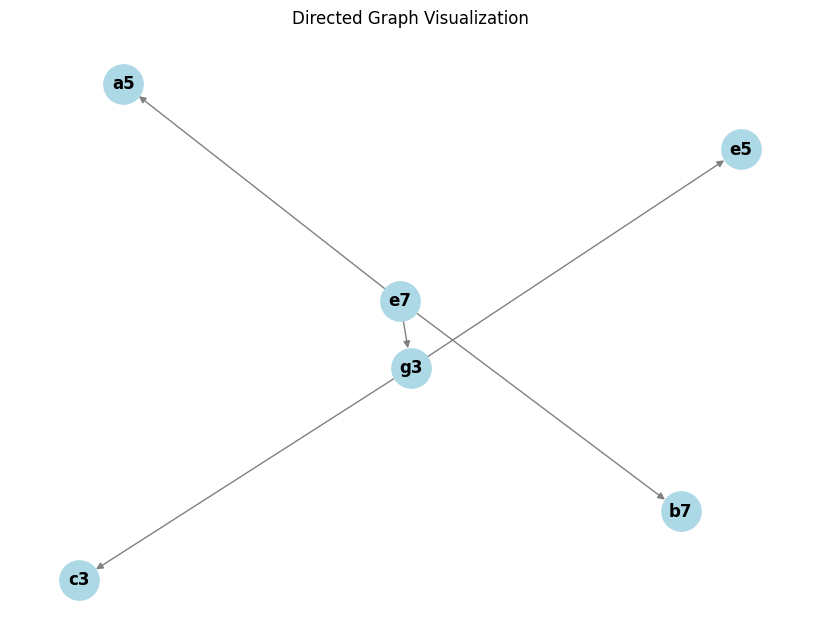

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_directed_graph(graph):
    G = nx.DiGraph()
    
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, font_weight='bold', edge_color='gray', arrows=True)

    edge_labels = {edge: '' for edge in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Directed Graph Visualization")
    plt.show()

visualize_directed_graph(directed_graph)